In [ ]:
!pip install -q ultralytics roboflow opencv-python matplotlib

### Driver Behavior Analysis
This file will explore object detection using a comprehensive dataset detailing various ascpects of driver behavior within a vehicle.
<ol>
<li>The first dataset contains driver distraction quantifiers, such as cellphone usage, eating whilst driving and looking around the vehicle.</li>
<li>The second dataset contains driver fatigue quantifiers.</li>
<li>The final dataset contains seatbelt images, ensuring the driver is appropriately buckled in, and not neglecting personal safety.</li>
</ol>

These datasets have been collected and combined in order to create a faux 'DMD-motor dataset'.

### Loading Libraries

In [ ]:
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
from glob import glob
import cv2

### Connecting to the RoboFlow API
Connecting to the RoboFlow API for dataset migration and model extraction.

In [ ]:
ROBOFLOW_API_KEY = 'ZeqDUbrUSOriIWblOi1E'

In [ ]:
rf = Roboflow(api_key = ROBOFLOW_API_KEY)

In [ ]:
ROBOFLOW_WORKSPACE = 'keshandirisa'
ROBOFLOW_PROJECT = 'dirisa_dmd_recreation-miovw'
ROBOFLOW_VERSION = 1

### Migrating the dataset
Currently, the dataset was specced and is hosted on the RoboFlow website, the dataset will be migrated to the current environment to be further evaluated

In [ ]:
project = rf.workspace(ROBOFLOW_WORKSPACE).project(ROBOFLOW_PROJECT)
dataset = project.version(ROBOFLOW_VERSION).download('yolov8')

for v in project.versions():
    print(f" - Version: {v.id}, Images: {v.images}, Created at: {v.created}")

loading Roboflow workspace...
loading Roboflow project...
 - Version: keshandirisa/dirisa_dmd_recreation-miovw/1, Images: 13375, Created at: 1764631966.373


In [ ]:
dataset_dir = Path(dataset.location)
data_yaml = dataset_dir / 'data.yaml'

print('Dataset directory: ', dataset_dir)
print('data.yaml path: ', data_yaml)

assert data_yaml.exists(), 'data.yaml file does not exist'

Dataset directory:  /content/Dirisa_DMD_recreation-1
data.yaml path:  /content/Dirisa_DMD_recreation-1/data.yaml


### Inspection
Dataset classes will be inspected, as well as a sample of training images to ensure the appropriate dataset was migrated.

In [ ]:
with open(data_yaml, 'r') as f:
  data_cfg = yaml.safe_load(f)

print('Classes: ', data_cfg.get('names'))
print('Train path:', data_cfg.get('train'))
print('Validation path:', data_cfg.get('val'))

Classes:  ['Drinking', 'Driver', 'Seat-Belt Detection - v5 2023-10-12 10-52pm', 'Smoking', 'Using Phone', 'closed_eye', 'closed_mouth', 'open_eye', 'open_mouth']
Train path: ../train/images
Validation path: ../valid/images


In [ ]:
# Grabbing Training Images as a visual check
train_imgs = glob(str(dataset_dir / 'train' / 'images'/ '*'))
print('Number of training images: ', len(train_imgs))

Number of training images:  9854


<ul>
<li>The training data consists of 9854 images</li>
<li>The validation data consists of 3058 images</li>
<li>The test data consists of 463 images</li>
</ul>

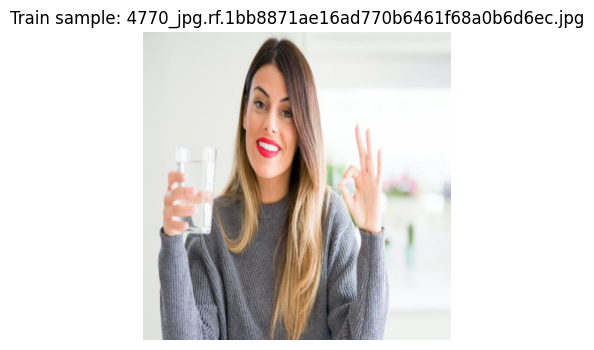

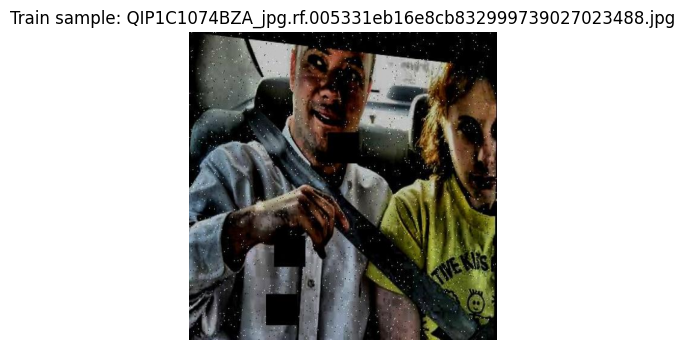

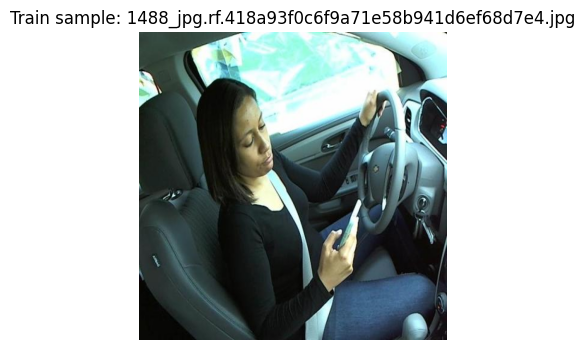

In [ ]:
for img_path in train_imgs[:3]:
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (6, 4))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Train sample: {Path(img_path).name}')
  plt.show()

### Model Specification
This section will detail model parameters, of the YOLOv11 model. Parameters were selected in order to optimise performance whilst remaining within reasonable computational and time constraints.

YOLOv11 is highly versatile and supports a broad range of computer vision tasks beyond simple object detection:
<ul>
<li>Multi-Task Support: Unlike earlier versions focused solely on detection, YOLOv11 supports Object Detection, Instance Segmentation, Image Classification, Pose Estimation, and Oriented Object Detection (OBB).</li>
<li>Real-Time Performance: It maintains the YOLO signature of high Frames Per Second (FPS), making it suitable for low-latency applications like autonomous driving and real-time surveillance.</li>
</ul>

In [ ]:
# checking if gpu acceleration is available
!nvidia-smi

Tue Dec  2 07:58:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
MODEL_WEIGHTS = 'yolo11n.pt'
EPOCHS = 25
BATCH_SIZE = 16
IMG_SIZE = 640
DEVICE = 0
RUN_NAME = 'driver_behavior_yolo11'

model = YOLO(MODEL_WEIGHTS)
model.info()

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

### Training the model

In [ ]:
results = model.train(
    data = str(data_yaml),
    epochs = EPOCHS,
    batch = BATCH_SIZE,
    imgsz = IMG_SIZE,
    device = DEVICE,
    name = RUN_NAME,
    pretrained = True,
    workers = 4,
    patience = 10 # early stopping
)

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Dirisa_DMD_recreation-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=driver_behavior_yolo113, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspec

### Model Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def evaluate_yolo_model(
    model,
    data_yaml,
    imgsz=640,
    device=0,
    conf=0.25,
    iou=0.5,
    results_dir=None,   # <- pass runs/detect/... directory to plot loss curves
):
    """
    Run validation for an Ultralytics YOLO model and show:
      - mAP metrics
      - Overall P / R / F1 / approx accuracy
      - Per-class metrics
      - Bar charts for AP, P, R, F1
      - Confusion matrix (if available)
      - Train & validation loss curves (if results.csv is available)
    """

    # ---- 1. Run validation ----
    metrics = model.val(
        data=str(data_yaml),
        imgsz=imgsz,
        device=device,
        conf=conf,
        iou=iou,
    )

    # ---- 2. Summary mAP metrics ----
    print("\n========== GLOBAL DETECTION METRICS ==========")
    print(f"mAP50-95 : {metrics.box.map:.4f}")
    print(f"mAP50    : {metrics.box.map50:.4f}")
    print(f"mAP75    : {metrics.box.map75:.4f}")

    # ---- 3. Per-class P/R/AP ----
    ap_per_class   = metrics.box.maps                  # AP per class
    prec_per_class = metrics.box.p                 # precision per class
    rec_per_class  = metrics.box.r                    # recall per class
    f1_per_class   = 2 * prec_per_class * rec_per_class / (prec_per_class + rec_per_class + 1e-9)

    # Approx per-class accuracy using P, R
    acc_per_class = []
    for P, R in zip(prec_per_class, rec_per_class):
        TP = R
        FP = TP * (1 / P - 1) if P > 0 else 0.0
        FN = 1 - R
        denom = TP + FP + FN
        acc = TP / denom if denom > 0 else 0.0
        acc_per_class.append(acc)
    acc_per_class = np.array(acc_per_class)

    overall_precision = float(np.mean(prec_per_class))
    overall_recall    = float(np.mean(rec_per_class))
    overall_f1        = float(np.mean(f1_per_class))
    overall_acc       = float(np.mean(acc_per_class))

    print("\n========== GLOBAL CLASSIFICATION SUMMARY ==========")
    print(f"Overall Precision : {overall_precision:.4f}")
    print(f"Overall Recall    : {overall_recall:.4f}")
    print(f"Overall F1        : {overall_f1:.4f}")
    print(f"Approx Accuracy   : {overall_acc:.4f}")

    # ---- 4. Per-class breakdown ----
    print("\n========== PER-CLASS METRICS ==========")
    for cls_id, cls_name in metrics.names.items():
        print(
            f"[{cls_id}] {cls_name:20s} | "
            f"AP={ap_per_class[cls_id]:.3f} | "
            f"P={prec_per_class[cls_id]:.3f} | "
            f"R={rec_per_class[cls_id]:.3f} | "
            f"F1={f1_per_class[cls_id]:.3f} | "
            f"Acc\u2248{acc_per_class[cls_id]:.3f}"
        )

    # ---- 5. Bar charts for AP, P, R, F1 ----
    classes = [metrics.names[i] for i in range(len(metrics.names))]
    x = np.arange(len(classes))

    def _barplot(values, title, ylabel):
        plt.figure(figsize=(max(8, len(classes) * 0.6), 4))
        plt.bar(x, values)
        plt.xticks(x, classes, rotation=45, ha="right")
        plt.title(title)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()

    _barplot(ap_per_class,   "Average Precision (AP) per Class", "AP")
    _barplot(prec_per_class, "Precision per Class",              "Precision")
    _barplot(rec_per_class,  "Recall per Class",                 "Recall")
    _barplot(f1_per_class,   "F1 Score per Class",               "F1")

    # ---- 6. Confusion matrix (if available) ----
    cm = None
    if hasattr(metrics, "confusion_matrix") and metrics.confusion_matrix is not None:
        try:
            cm = metrics.confusion_matrix.matrix
        except AttributeError:
            cm = getattr(metrics.confusion_matrix, "matrix", None)

    if cm is not None:
        # For detection tasks, confusion matrix is (nc+1, nc+1); last row/col are background
        if cm.shape[0] == len(classes) + 1:
            cm = cm[:-1, :-1]

        cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)

        plt.figure(figsize=(max(8, len(classes) * 0.6), max(6, len(classes) * 0.6)))
        im = plt.imshow(cm_norm, interpolation="nearest", cmap="Blues")
        plt.title("Normalized Confusion Matrix")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, ha="right")
        plt.yticks(tick_marks, classes)
        plt.ylabel("True Class")
        plt.xlabel("Predicted Class")
        plt.tight_layout()
        plt.show()
    else:
        print("\n[Info] Confusion matrix not available on metrics; "
              "update Ultralytics if you need it.")

    # ---- 7. Train & validation loss curves (from results.csv) ----
    if results_dir is None:
        # Try to infer from model.trainer if still in the same session
        save_dir = getattr(getattr(model, "trainer", None), "save_dir", None)
        if save_dir is not None:
            results_dir = Path(save_dir)
        else:
            print("\n[Info] results_dir not provided and could not infer from model.trainer; "
                  "skipping loss curves.")
            results_csv = None
    else:
        results_dir = Path(results_dir)
        results_csv = results_dir / "results.csv"

    if results_dir is not None:
        results_csv = results_dir / "results.csv"
        if results_csv.exists():
            print(f"\n[Info] Loading training history from: {results_csv}")
            df = pd.read_csv(results_csv)

            if "epoch" not in df.columns:
                print("[Warning] 'epoch' column not found in results.csv; skipping loss curves.")
            else:
                # Identify loss columns
                train_loss_cols = [c for c in df.columns if c.startswith("train/") and c.endswith("_loss")]
                val_loss_cols   = [c for c in df.columns if c.startswith("val/")   and c.endswith("_loss")]

                if not train_loss_cols or not val_loss_cols:
                    print("[Warning] No train/val loss columns found in results.csv; "
                          "column names may differ in your version.")
                else:
                    df["train_total_loss"] = df[train_loss_cols].sum(axis=1)
                    df["val_total_loss"]   = df[val_loss_cols].sum(axis=1)

                    plt.figure(figsize=(8, 5))
                    plt.plot(df["epoch"], df["train_total_loss"], label="Train total loss")
                    plt.plot(df["epoch"], df["val_total_loss"],   label="Val total loss")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.title("Train vs Validation Loss")
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()
        else:
            print(f"\n[Info] results.csv not found in {results_dir}; skipping loss curves.")

    return {
        "metrics": metrics,
        "ap_per_class": ap_per_class,
        "precision_per_class": prec_per_class,
        "recall_per_class": rec_per_class,
        "f1_per_class": f1_per_class,
        "accuracy_per_class": acc_per_class,
        "overall": {
            "precision": overall_precision,
            "recall": overall_recall,
            "f1": overall_f1,
            "accuracy": overall_acc,
            "map50_95": float(metrics.box.map),
            "map50": float(metrics.box.map50),
            "map75": float(metrics.box.map75),
        },
    }

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1223.3±326.1 MB/s, size: 29.0 KB)
val: Scanning /content/Dirisa_DMD_recreation-1/valid/labels.cache... 3058 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3058/3058 6.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 192/192 6.8it/s 28.1s
                   all       3058       6903      0.877      0.861      0.889      0.592
              Drinking        381        406      0.881      0.889      0.933      0.746
                Driver       1528       1703      0.925      0.934      0.948      0.757
Seat-Belt Detection - v5 2023-10-12 10-52pm        179        214      0.728      0.664      0.733      0.385
               Smoking        694        720      0.744      0.625      0.675      0.355
           Using Phone        615        712      0.788      0.725      0.781      0.56

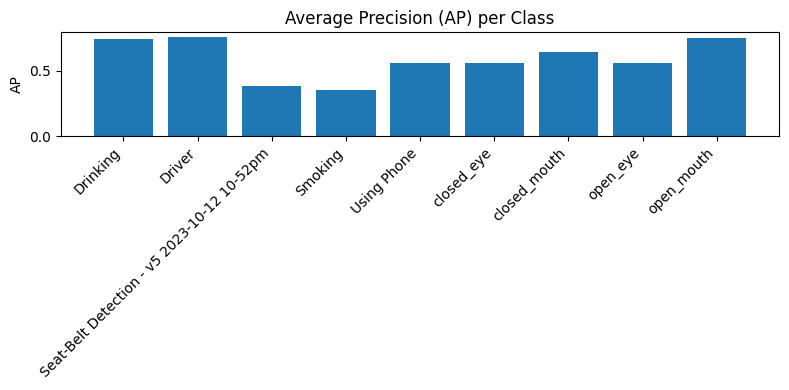

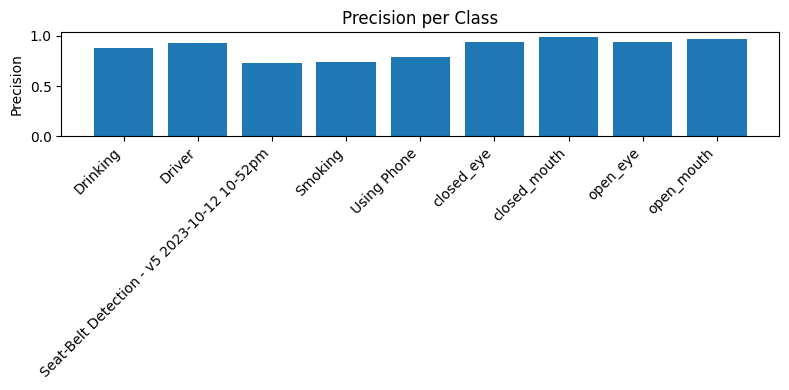

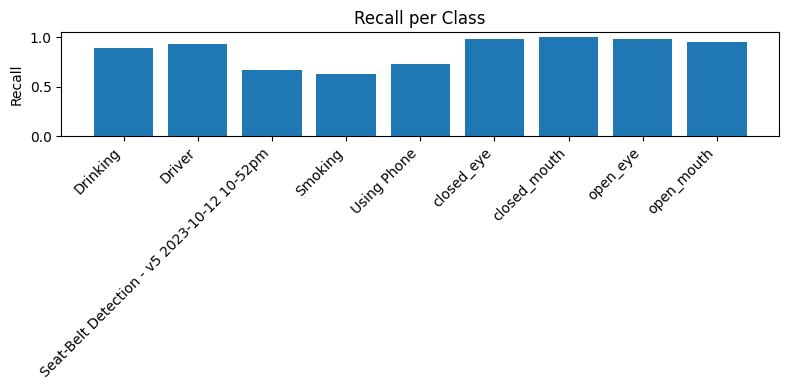

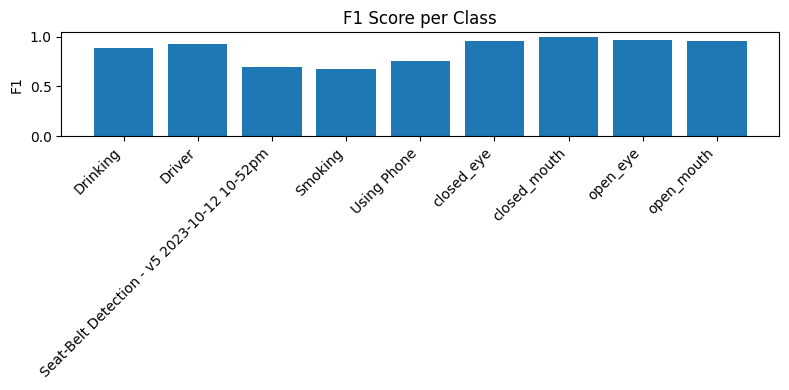

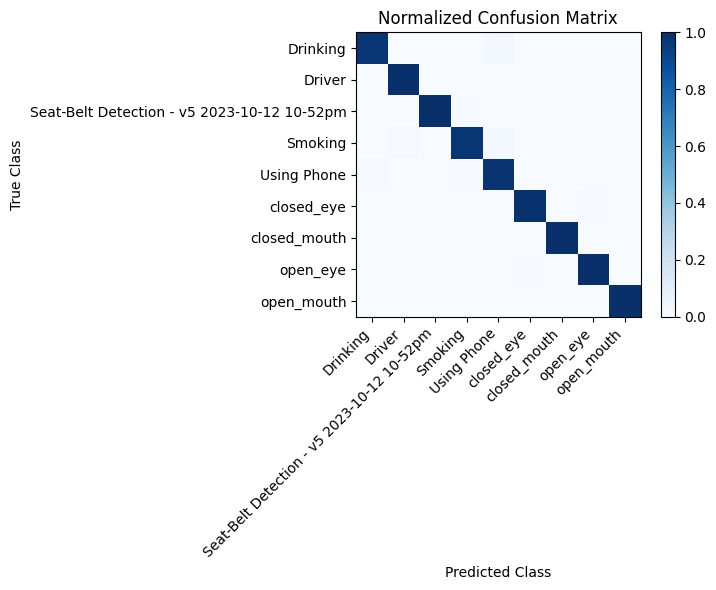


[Info] Loading training history from: /content/runs/detect/driver_behavior_yolo113/results.csv


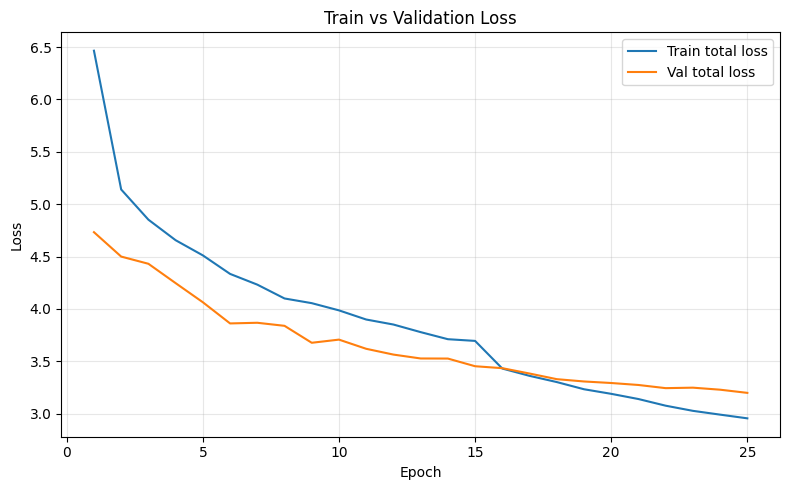

In [ ]:
results_dict = evaluate_yolo_model(
    model,
    data_yaml = data_yaml,
    imgsz = IMG_SIZE,
    device = DEVICE,
    conf = 0.25,
    iou = 0.5,
    # results_dir optional; if omitted, it tries model.trainer.save_dir
)

### Visualising predictions on validation images
Drawing bounding boxes on validation images

In [ ]:
val_imgs = glob(str(dataset_dir / 'valid' / 'images'/ '*'))
print('Number of validation images: ', len(val_imgs))

Number of validation images:  3058


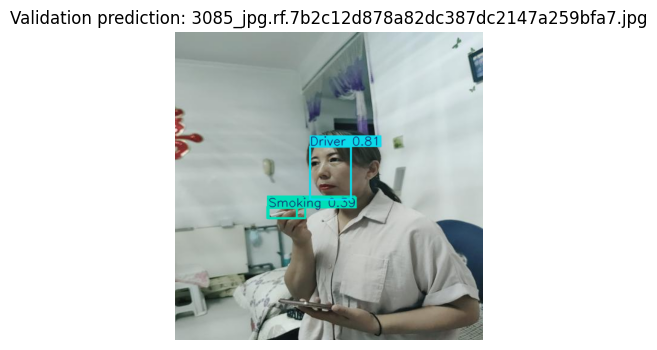

In [ ]:
for img_path in val_imgs[:3]:
  results = model.predict(
      source = img_path,
      imgsz = IMG_SIZE,
      conf = 0.25,
      device = DEVICE,
      verbose = False
  )

annoted = results[0].plot() # draws bounding boxes and labels
annoted = cv2.cvtColor(annoted, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (6, 4))
plt.imshow(annoted)
plt.axis('off')
plt.title(f'Validation prediction: {Path(img_path).name}')
plt.show()

### Loading the Best Model Weights

In [ ]:
best_weights = Path('runs')/'detect'/'driver_behavior_yolo113'/'weights'/'best.pt'
print('Best weights path: ', best_weights.resolve())
assert best_weights.exists(), 'best.pt does not exist'

y11_model = YOLO(str(best_weights))

Best weights path:  /content/runs/detect/driver_behavior_yolo113/weights/best.pt


#### Run Predictions on test images

In [ ]:
test_imgs = glob(str(dataset_dir / 'test' / 'images'/ '*'))
print('Number of test images: ', len(test_imgs))

Number of test images:  463


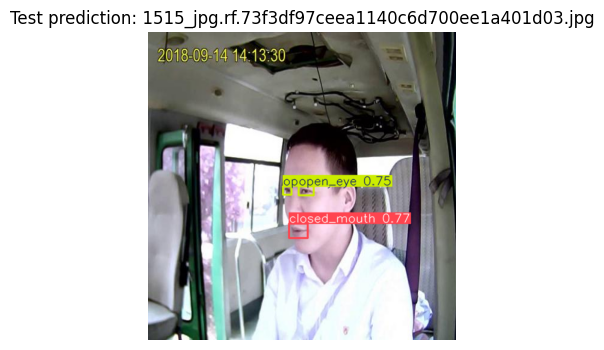

In [ ]:
for img_path in test_imgs[:3]:
  results = y11_model.predict(
       source = img_path,
       imgsz = IMG_SIZE,
       conf = 0.25,
       device = DEVICE,
       verbose = False
  )

annotated = results[0].plot()
annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (6, 4))
plt.imshow(annotated)
plt.axis('off')
plt.title(f'Test prediction: {Path(img_path).name}')
plt.show()

### Risk Analysis

In [ ]:
# creating a risk map to dataset classes to a risk category
risk_map = {
  'Driver': 0,
  'Drinking' : 1,
  'Using Phone' : 2,
  'Smoking' : 3,
  'closed_eye' : 4,
  'open_eye' : 0,
  'closed_mouth' : 0,
  'open_mouth' : 5,
  'Seat-Belt Detection - v5 2023-10-12 10:52pm' : 0

}

DEFAULT_RISK_LVL = 0

In [ ]:
def get_image_risk_label(label_path: Path, class_names, risk_map, default=0):
    """
    Read a YOLO label file and return an integer risk level for the image.
    We take the MAX risk among all objects in the image.
    """
    if not label_path.exists():
        return default

    risks = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            cls_id = int(parts[0])
            cls_name = class_names[cls_id]
            risks.append(risk_map.get(cls_name, default))

    if not risks:
        return default
    return max(risks)


In [ ]:
def risk_level_to_binary(risk_level: int) -> int:
    """
    Convert multi-level risk (0,1,2,...) to binary:
    0 = safe, 1 = risky
    """
    return 1 if risk_level > 0 else 0

In [ ]:
import numpy as np
import cv2

class_names = data_cfg['names']
n_classes = len(class_names)

def features_from_results(results, n_classes: int):
    """
    Build a fixed-length feature vector from YOLO Results for one image.
    For each class: [count, max_conf, mean_area].
    """
    feat = np.zeros(n_classes * 3, dtype=np.float32)

    img_h, img_w = results.orig_img.shape[:2]
    boxes = results.boxes

    if boxes is None or len(boxes) == 0:
        return feat

    for box in boxes:
        cls = int(box.cls.item())
        conf = float(box.conf.item())
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        area = (x2 - x1) * (y2 - y1) / (img_w * img_h + 1e-9)  # normalized

        base = cls * 3
        # count
        feat[base] += 1
        # max confidence
        feat[base + 1] = max(feat[base + 1], conf)
        # sum of areas for now; convert to mean later
        feat[base + 2] += area

    # Convert area sums to means
    for cls in range(n_classes):
        base = cls * 3
        count = feat[base]
        if count > 0:
            feat[base + 2] /= count

    return feat

In [ ]:
from glob import glob

split = "valid"  # or "train"
img_dir = dataset_dir / split / "images"
lbl_dir = dataset_dir / split / "labels"

image_paths = sorted(glob(str(img_dir / "*")))
print(f"{split} images used for risk model:", len(image_paths))

X, y = [], []

for img_path in image_paths:
    img_path = Path(img_path)
    label_path = lbl_dir / (img_path.stem + ".txt")

    # Ground-truth risk label
    risk_level = get_image_risk_label(label_path, class_names, risk_map, DEFAULT_RISK_LVL)
    y_bin = risk_level_to_binary(risk_level)

    # YOLO detections as features
    # (We can resize to IMG_SIZE for consistency, but YOLO handles it internally.)
    results = y11_model(str(img_path), imgsz=IMG_SIZE, conf=0.25, verbose=False)[0]
    feat = features_from_results(results, n_classes=n_classes)

    X.append(feat)
    y.append(y_bin)

X = np.stack(X, axis=0)
y = np.array(y, dtype=np.int64)

print("Feature matrix shape:", X.shape)
print("Binary labels shape :", y.shape, "| #risky:", y.sum(), "| #safe:", (y == 0).sum())

valid images used for risk model: 3058
Feature matrix shape: (3058, 27)
Binary labels shape : (3058,) | #risky: 2195 | #safe: 863


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Apply SMOTE only on the training set
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

base_clf = LogisticRegression(max_iter=500)
risk_clf = CalibratedClassifierCV(base_clf, method="isotonic", cv=3)

risk_clf.fit(X_train, y_train)

# Evaluate
probs_val = risk_clf.predict_proba(X_val)[:, 1]  # P(risky)
preds_val = (probs_val >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_val, probs_val))
print("\nClassification report:")
print(classification_report(y_val, preds_val, target_names=["safe", "risky"]))

print("Confusion matrix (safe=0, risky=1):")
print(confusion_matrix(y_val, preds_val))

# Save risk model
joblib.dump(risk_clf, "risk_classifier.joblib")
print("Saved risk classifier to risk_classifier.joblib")

ROC AUC: 0.9811776633705084

Classification report:
              precision    recall  f1-score   support

        safe       1.00      0.91      0.95       173
       risky       0.96      1.00      0.98       439

    accuracy                           0.97       612
   macro avg       0.98      0.95      0.97       612
weighted avg       0.97      0.97      0.97       612

Confusion matrix (safe=0, risky=1):
[[157  16]
 [  0 439]]
Saved risk classifier to risk_classifier.joblib


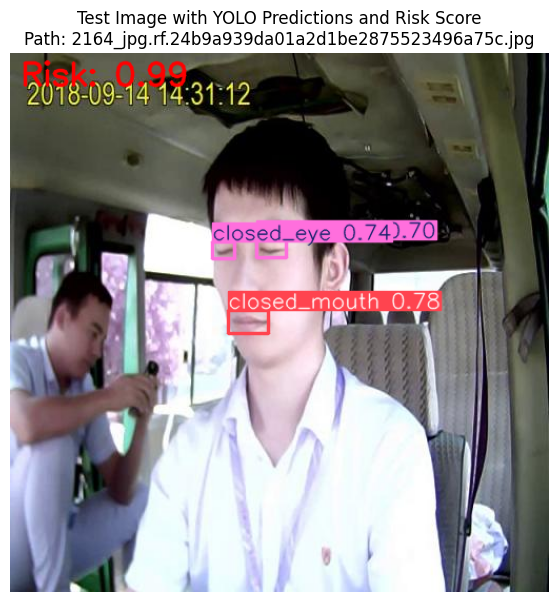

In [ ]:
# Reload (optional, if in a new session)
y11_model = YOLO(str(best_weights))
risk_clf = joblib.load("risk_classifier.joblib")

def risk_features_from_frame(results):
    return features_from_results(results, n_classes=n_classes).reshape(1, -1)

# --- MODIFIED: Replaced video capture and cv2.imshow with static image display ---

# Choose a sample test image for demonstration
if test_imgs:
    sample_img_path = test_imgs[0] # Use the first image from test_imgs
else:
    print("No test images found to display.")
    sample_img_path = None

if sample_img_path:
    # Read the image using OpenCV
    frame = cv2.imread(sample_img_path)
    if frame is None:
        print(f"Error: Could not load image {sample_img_path}")
    else:
        # YOLO inference
        results = y11_model(frame, imgsz=IMG_SIZE, conf=0.25, verbose=False)[0]

        # Risk features + prediction
        feat = risk_features_from_frame(results)
        prob_risky = float(risk_clf.predict_proba(feat)[0, 1])  # P(risky)

        # Draw detections
        annotated = results.plot() # This returns a BGR image by default from YOLO
        annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib

        # Overlay risk
        text = f"Risk: {prob_risky:.2f}"
        if prob_risky < 0.33:
            color = (0, 255, 0)   # green (RGB)
        elif prob_risky < 0.66:
            color = (255, 255, 0) # yellow (RGB)
        else:
            color = (255, 0, 0)   # red (RGB)

        # For drawing text, cv2.putText expects BGR or RGB, but the colors must match
        # the image's channel order. Since 'annotated' is now RGB, use RGB colors.
        cv2.putText(
            annotated,
            text,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            color,
            2,
            cv2.LINE_AA
        )

        # Display using matplotlib
        plt.figure(figsize=(10, 7))
        plt.imshow(annotated)
        plt.title(f'Test Image with YOLO Predictions and Risk Score\nPath: {Path(sample_img_path).name}')
        plt.axis('off')
        plt.show()
else:
    print("No sample image to process.")

# Removed cv2.VideoCapture, cv2.imshow, cv2.waitKey, and cv2.destroyAllWindows.

### Saving the model


In [ ]:
joblib.dump(risk_clf, 'risk_classifier.joblib')

['risk_classifier.joblib']

In [ ]:
class YOLORiskModel:
    def __init__(self, yolo_weights_path: str, risk_clf_path: str, n_classes: int, imgsz: int = 640):
        self.yolo = YOLO(yolo_weights_path)
        self.risk_clf = joblib.load(risk_clf_path)
        self.n_classes = n_classes
        self.imgsz = imgsz

    def features_from_results(self, results):
        """
        Reuse your existing `features_from_results` logic here.
        This should return a 1D numpy array of shape (n_features,).
        """
        # Example placeholder – replace with your actual implementation:
        return features_from_results(results, n_classes=self.n_classes)

    def predict(self, image):
        """
        image: np.ndarray (BGR or RGB) or path string – whatever YOLO accepts.
        returns: dict with boxes, scores, classes, risk_prob, raw_results
        """
        # Run YOLO
        res = self.yolo(image, imgsz=self.imgsz, conf=0.25, verbose=False)[0]

        # Build risk features
        feat = self.features_from_results(res).reshape(1, -1)

        # Risk probability (P(risky))
        prob_risky = float(self.risk_clf.predict_proba(feat)[0, 1])

        # Extract detections in a convenient format
        boxes = res.boxes.xyxy.cpu().numpy() if res.boxes is not None else np.zeros((0, 4))
        scores = res.boxes.conf.cpu().numpy() if res.boxes is not None else np.zeros((0,))
        classes = res.boxes.cls.cpu().numpy().astype(int) if res.boxes is not None else np.zeros((0,), dtype=int)

        return {
            "boxes": boxes,
            "scores": scores,
            "classes": classes,
            "risk_prob": prob_risky,
            "raw_results": res,   # optional, for plotting etc.
        }

In [ ]:
# Generate FEATURE_NAMES dynamically based on class_names and feature structure
# Assuming n_classes and class_names are already defined from data_cfg
FEATURE_NAMES = []
for class_name in class_names:
    FEATURE_NAMES.append(f"{class_name}_count")
    FEATURE_NAMES.append(f"{class_name}_max_conf")
    FEATURE_NAMES.append(f"{class_name}_mean_area")

# Verification: check if the length matches n_classes * 3
# print(f"Generated {len(FEATURE_NAMES)} feature names.")
# assert len(FEATURE_NAMES) == n_classes * 3, "Feature names length mismatch!"


### Adding Explainable AI
Adding XAI to the pipeline in order to qu

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt

class YOLORiskExplainer:
    def __init__(
        self,
        yolo_risk_model: "YOLORiskModel",
        background_frames,
        max_background: int = 100,
        feature_names=None,
    ):
        """
        yolo_risk_model : instance of your YOLORiskModel wrapper
        background_frames : list/iterable of frames (np.ndarray) representative of your data
        max_background : max number of background samples for SHAP
        feature_names : list of strings for features (same length as feature vector)
        """
        self.model = yolo_risk_model
        self.feature_names = feature_names

        # Build background feature matrix from a sample of frames
        self.X_background = self._build_background(background_frames, max_background)

        # SHAP KernelExplainer uses the model's predict_proba as a black box
        self.explainer = shap.KernelExplainer(
            self._risk_predict_proba,
            self.X_background
        )

    def _build_background(self, frames, max_background):
        feats = []
        for i, frame in enumerate(frames):
            if i >= max_background:
                break
            res = self.model.yolo(
                frame,
                imgsz=self.model.imgsz,
                conf=0.25,
                verbose=False
            )[0]
            f = self.model.features_from_results(res)
            feats.append(f)
        X_bg = np.vstack(feats)
        return X_bg

    def _risk_predict_proba(self, X):
        """
        X : np.ndarray of shape (n_samples, n_features)
        Returns P(risky) for each sample, shape (n_samples,)
        """
        # risk_clf.predict_proba returns (n_samples, 2)
        proba = self.model.risk_clf.predict_proba(X)[:, 1]
        return proba

    def explain_frame(self, frame):
        """
        Run YOLO + risk model, then compute SHAP attributions for this frame's risk.
        Returns a dict with everything you need.
        """
        # Run full model
        results = self.model.yolo(
            frame,
            imgsz=self.model.imgsz,
            conf=0.25,
            verbose=False
        )[0]

        feat = self.model.features_from_results(results).reshape(1, -1)

        # SHAP values for this single instance
        shap_values = self.explainer.shap_values(feat)[0]  # returns list; [0] is for our single sample

        # Risk probability
        prob_risky = float(self.model.risk_clf.predict_proba(feat)[0, 1])

        return {
            "results": results,             # YOLO detections (boxes, etc.)
            "features": feat.flatten(),     # 1D feature vector
            "shap_values": shap_values,     # 1D array, same length as features
            "risk_prob": prob_risky,
        }

    def plot_feature_importance(self, explanation, top_k: int = 15):
        """
        explanation: output of explain_frame
        Shows a bar plot of the top K contributors to the risk score.
        """
        shap_vals = explanation["shap_values"]
        feats = explanation["features"]

        # Indices sorted by absolute influence
        idxs = np.argsort(np.abs(shap_vals))[::-1][:top_k]

        important_shap = shap_vals[idxs]
        important_feats = feats[idxs]

        if self.feature_names is not None:
            names = [self.feature_names[i] for i in idxs]
        else:
            names = [f"f{i}" for i in idxs]

        # Horizontal bar chart: positive = pushes towards risky, negative = towards safe
        plt.figure(figsize=(8, 0.5 * len(idxs) + 1))
        y_pos = np.arange(len(idxs))

        plt.barh(y_pos, important_shap)
        plt.yticks(y_pos, names)
        plt.axvline(0, linestyle="--", linewidth=1)
        plt.gca().invert_yaxis()

        plt.title("Feature contributions to risk (SHAP values)")
        plt.xlabel("Contribution to risk probability (ΔP(risky))")
        plt.tight_layout()
        plt.show()

    def plot_waterfall(self, explanation):
        """
        Optional: SHAP-style waterfall plot for a single instance.
        This uses shap's own plotting if you prefer.
        """
        shap_vals = explanation["shap_values"]
        feats = explanation["features"]

        # Build a SHAP Explanation object
        exp = shap.Explanation(
            values=shap_vals,
            base_values=self.explainer.expected_value,
            data=feats,
            feature_names=self.feature_names,
        )

        shap.plots.waterfall(exp, max_display=15)

  0%|          | 0/1 [00:00<?, ?it/s]

Risk probability: 0.9867988410505175


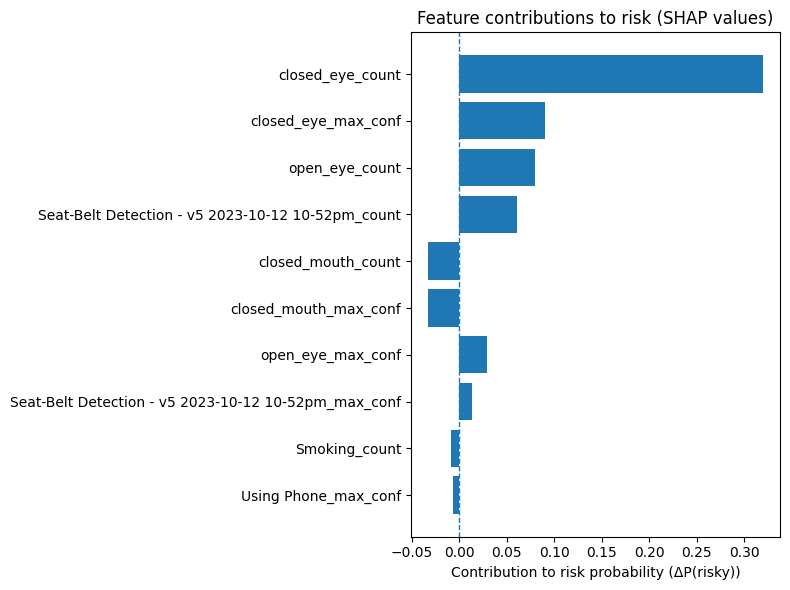

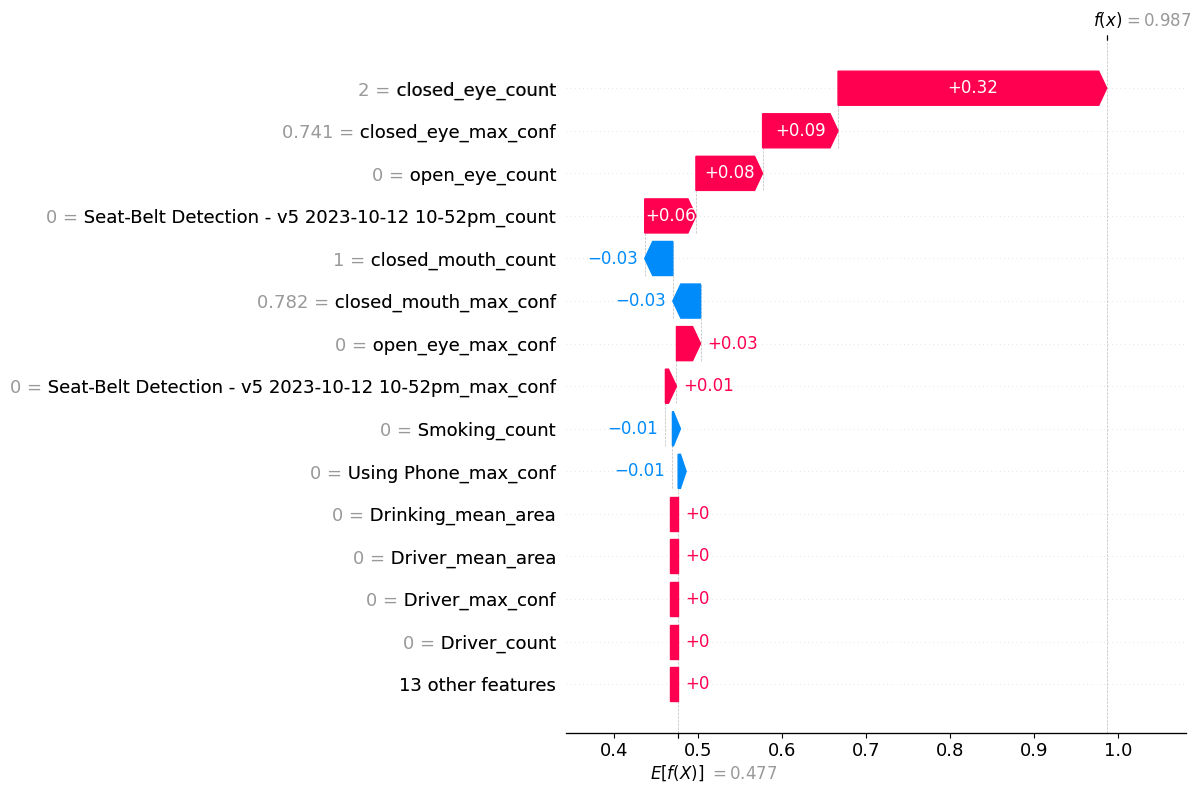

In [ ]:
# 1. Build / load your YOLORiskModel wrapper
yolo_risk_model = YOLORiskModel(
    yolo_weights_path=str(best_weights),
    risk_clf_path="risk_classifier.joblib",
    n_classes=n_classes,
    imgsz=IMG_SIZE,
)

# 2. Prepare some background frames (e.g. subset of your test images)
background_frames = []
for img_path in test_imgs[:200]:  # choose a subset
    frame = cv2.imread(img_path)
    if frame is not None:
        background_frames.append(frame)

# 3. Init the explainer
explainer = YOLORiskExplainer(
    yolo_risk_model=yolo_risk_model,
    background_frames=background_frames,
    max_background=50,
    feature_names=FEATURE_NAMES,
)

# 4. Explain a single frame
frame = cv2.imread(test_imgs[0])
explanation = explainer.explain_frame(frame)

print("Risk probability:", explanation["risk_prob"])
explainer.plot_feature_importance(explanation, top_k=10)
explainer.plot_waterfall(explanation)

In [ ]:
def highlight_important_classes(frame, explanation, yolo_results, feature_names, class_id_map):
    """
    class_id_map: dict like {"num_phone_usage": phone_cls_id, ...}
    """
    shap_vals = explanation["shap_values"]
    feats = explanation["features"]

    # Find features with strong positive contributions
    for fname, cls_id in class_id_map.items():
        if fname in feature_names:
            idx = feature_names.index(fname)
            if shap_vals[idx] > 0:  # positive contribution to risk
                # highlight all boxes for this class
                for box, cls in zip(yolo_results.boxes.xyxy, yolo_results.boxes.cls):
                    if int(cls) == cls_id:
                        x1, y1, x2, y2 = map(int, box)
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
                        cv2.putText(frame, fname, (x1, y1 - 5),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    return frame

In [ ]:

def highlight_important_classes(frame, explanation, yolo_results, feature_names, class_id_map):
    """
    frame: np.ndarray (BGR), ideally the image returned by yolo_results.plot()
    explanation: dict from explainer.explain_frame
    yolo_results: YOLO result object (explanation["results"])
    feature_names: list[str] – same order as your feature vector
    class_id_map: dict[str, int] mapping feature name -> YOLO class id
    """
    shap_vals = explanation["shap_values"]
    feats = explanation["features"]

    # Nothing to draw if there are no boxes
    if yolo_results.boxes is None or len(yolo_results.boxes) == 0:
        return frame

    for fname, cls_id in class_id_map.items():
        if fname not in feature_names:
            continue

        idx = feature_names.index(fname)
        contrib = shap_vals[idx]

        # Only highlight if this feature increases risk
        if contrib <= 0:
            continue

        for box, cls in zip(yolo_results.boxes.xyxy, yolo_results.boxes.cls):
            if int(cls) != cls_id:
                continue

            x1, y1, x2, y2 = map(int, box)

            # Thicker red rectangle to show "important" detections
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
            cv2.putText(
                frame,
                f"{fname} (+{contrib:.2f})",
                (x1, max(0, y1 - 10)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 255),
                2,
                cv2.LINE_AA,
            )

    return frame

  0%|          | 0/1 [00:00<?, ?it/s]

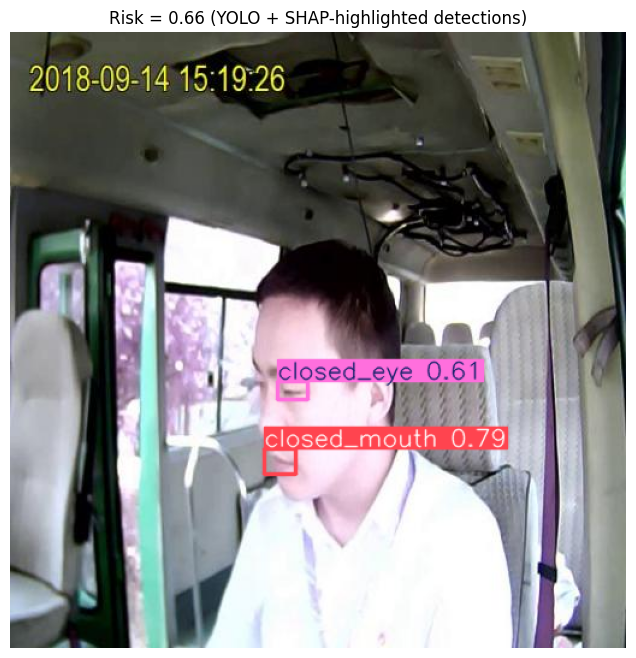

In [ ]:
# 1. Load a test image
frame = cv2.imread(test_imgs[40])
if frame is None:
    raise ValueError(f"Could not load test image: {test_imgs[0]}")

# 2. Run SHAP explanation
explanation = explainer.explain_frame(frame)
results = explanation["results"]  # YOLO results

# 3. Define mapping between features and YOLO classes
#    Make sure these IDs match your YOLO model's class indices
class_id_map = {
    "num_phone_usage": 3,
    "num_no_seatbelt": 5,
    "num_driver": 0,
}

# 4. Get YOLO's own annotated image (boxes + labels)
annotated = results.plot()        # BGR image with standard YOLO boxes/labels

# 5. Overlay XAI highlights on top of YOLO annotations
highlighted = highlight_important_classes(
    frame=annotated,
    explanation=explanation,
    yolo_results=results,
    feature_names=FEATURE_NAMES,
    class_id_map=class_id_map,
)

# 6. Display final image
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Risk = {explanation['risk_prob']:.2f} (YOLO + SHAP-highlighted detections)")
plt.show()